## Overview

This demo demostrates the differing behavior of the various ICVIs implemented in `ClusterValidityIndices.jl`.
Here, we load a simple dataset and run a basic clustering algorithm to prescribe a set of clusters to the features.
We will take advantage of the fact that we can compute a criterion value at every step by running the ICVI alongside an online clustering algorithm.

## Online Clustering

### Data Setup

First, we must load all of our dependencies.
We will load the `ClusterValidityIndices.jl` along with some data utilities and the Julia `Clustering.jl` package to cluster that data.

In [1]:
using ClusterValidityIndices    # CVI/ICVI
using AdaptiveResonance         # DDVFA
using MLDatasets                # Iris dataset
using DataFrames                # DataFrames, necessary for MLDatasets.Iris()
using MLDataUtils               # Shuffling and splitting
using Printf                    # Formatted number printing
using Plots                     # Plots frontend
gr()                            # Use the default GR backend explicitly
theme(:dracula)                 # Change the theme for fun

We will download the Iris dataset for its small size and benchmark use for clustering algorithms.

In [2]:
iris = Iris(as_df=false)
features, labels = iris.features, iris.targets

([5.1 4.9 … 6.2 5.9; 3.5 3.0 … 3.4 3.0; 1.4 1.4 … 5.4 5.1; 0.2 0.2 … 2.3 1.8], InlineStrings.String15["Iris-setosa" "Iris-setosa" … "Iris-virginica" "Iris-virginica"])

Because the MLDatasets package gives us Iris labels as strings, we will use the `MLDataUtils.convertlabel` method with the `MLLabelUtils.LabelEnc.Indices` type to get a list of integers representing each class:}

In [3]:
labels = convertlabel(LabelEnc.Indices{Int}, vec(labels))
unique(labels)

3-element Vector{Int64}:
 1
 2
 3

### ART Online Clustering

Adaptive Resonance Theory (ART) is a neurocognitive theory that is the basis of a class of online clustering algorithms.
Because these clustering algorithms run online, we can both cluster and compute a new criterion value at every step.
For more on these ART algorithms, see [`AdaptiveResonance.jl`](https://github.com/AP6YC/AdaptiveResonance.jl).

In [4]:
# Create a Distributed Dual-Vigilance Fuzzy ART (DDVFA) module with default options
art = DDVFA()
typeof(art)

AdaptiveResonance.DDVFA

Because we are streaming clustering, we must setup the internal data setup of the DDVFA module.
This is akin to doing some data preprocessing and communicating the dimension of the data, bounds, etc. to the module beforehand.

In [5]:
# Setup the data configuration for the module
data_setup!(art, features)
# Verify that the data is setup
art.config.setup

true

We can now cluster and get the criterion values online.
We will do this by creating many ICVI objects, setting up containers for the iterations, and then iterating.

In [6]:
# Create many ICVI objects
icvis = [
    CH(),
    cSIL(),
    DB(),
    GD43(),
    GD53(),
    PS(),
    rCIP(),
    WB(),
    XB(),
]

# Setup the online/streaming clustering
n_samples = length(labels)          # Number of samples
n_icvi = length(icvis)              # Number of ICVIs being computed
c_labels = zeros(Int, n_samples)    # Clustering labels
criterion_values = zeros(n_icvi, n_samples) # ICVI outputs

# Iterate over all samples
for ix = 1:n_samples
    # Extract one sample
    sample = features[:, ix]
    # Cluster the sample online
    c_labels[ix] = train!(art, sample)
    # Get the new criterion values (ICVI output)
    for jx = 1:n_icvi
        criterion_values[jx, ix] = get_cvi!(icvis[jx], sample, c_labels[ix])
    end
end

# See the matrix of criterion values
criterion_values

9×150 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  185.974      187.456
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     -89.6551     -82.4838
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.608095     0.605218
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.396107     0.399748
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.0733091    0.073983
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   -1.37173     -1.38178
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.173769     0.173208
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.967875     0.966892
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.961858     0.957701

We can inspect the final ICVI values to see how they differ:

In [7]:
criterion_values[:, end]

9-element Vector{Float64}:
 187.45626993623438
 -82.48378464919992
   0.6052176668598529
   0.39974779348978295
   0.07398295617634965
  -1.3817781684104142
   0.17320828663116808
   0.9668921720338003
   0.9577014813738303

Next, we would like to visualize these CVI trendlines over time with some plotting.
We can try plotting these trendlines all over one another

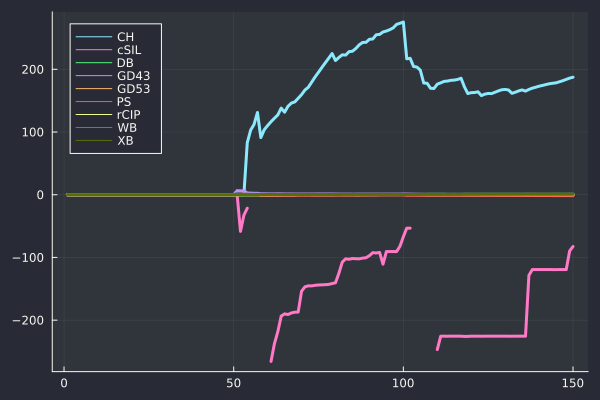

In [8]:
# Define a simple function for plotting
function plot_cvis(range)
    # Create the plotting object
    p = plot(legend=:topleft)
    # Iterate over the range of ICVI indices provided
    for jx = range
        # Plot the ICVI criterion values versus sample index
        plot!(
            p,                              # Modify the plot object
            1:n_samples,                    # x-axis iteration
            criterion_values[jx, :],        # y-axis criterion value
            linewidth=3,                    # Thicken the lines for visibility
            label=string(typeof(icvis[jx])) # Label is the type of CVI
        )
    end
    # Return the plotting object for IJulia display
    return p
end

# Plot all of the ICVIs tested here
plot_cvis(1:n_icvi)

We see from the final values that the CH and cSIL metrics behave very differently from the other metrics, so we should plot them separately to see them in better detail.

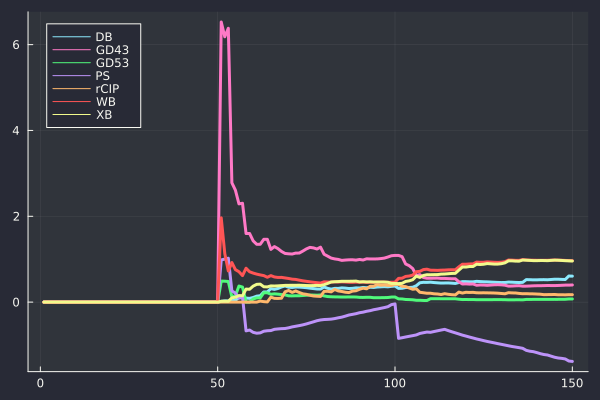

In [9]:
# Exclude CH and cSIL
plot_cvis(3:n_icvi)

This plot shows that the icvis all have unique behaviors as the clustering process continues incrementally.

In [10]:
png("assets/icvi-comparision") #hide

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*